# **Sistem Rekomendasi Film dan Acara TV Netflix**

## **Sumber Dataset**


https://www.kaggle.com/datasets/shivamb/netflix-shows



*   **Nama:** Maylina Nur'aini
*   **Email:** maylinanuraini@gmail.com
*   **ID Dicoding:** MC444D5X0679



# **Import Library**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# **Data Loading**

In [2]:
# Upload fie json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maylina","key":"b5f64cad00fd18b3dba21521742aea88"}'}

In [4]:
# Setup API Key Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Netflix Shows dari Kaggle
!kaggle datasets download -d shivamb/netflix-shows

# Unzip file dataset
!unzip netflix-shows.zip

Dataset URL: https://www.kaggle.com/datasets/shivamb/netflix-shows
License(s): CC0-1.0
  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 547MB/s]
Archive:  netflix-shows.zip
  inflating: netflix_titles.csv      


In [6]:
# Membaca file csv
df = pd.read_csv("netflix_titles.csv")

# Menampilkan 5 baris pertama
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Pada Data loading ini, file kaggle.json yang berisi kunci API Kaggle diunggah untuk melakukan autentikasi. Kunci ini kemudian dipindahkan ke direktori khusus agar sistem dapat mengenali dan mengizinkan akses ke Kaggle melalui API. Setelah proses autentikasi berhasil, dataset bernama Netflix Movies and TV Shows diunduh menggunakan perintah API Kaggle. File dataset yang biasanya berupa arsip ZIP kemudian diekstrak untuk mendapatkan file CSV yang berisi data. Selanjutnya, file CSV tersebut dibaca menggunakan pustaka pandas ke dalam sebuah DataFrame. Untuk mendapatkan gambaran awal mengenai isi dataset, lima baris pertama dari DataFrame tersebut ditampilkan menggunakan fungsi ```df.head()```. Langkah ini memudahkan dalam memahami struktur dan tipe data sebelum melanjutkan ke proses analisis lebih lanjut.

# **Data Understanding**

In [7]:
# Menampilkan informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [9]:
# Menampilkan statistik deskriptif kolom numerik
df.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [10]:
# Menampilkan jumlah baris dan kolom dalam bentuk tuple
df.shape

(8807, 12)

In [11]:
# Menampilkan jumlah nilai unik di setiap kolomnya
df.nunique()

,0
show_id,8807
type,2
title,8807
director,4528
cast,7692
country,748
date_added,1767
release_year,74
rating,17
duration,220


In [12]:
# Menampilkan missing values
df.isna().sum()

,0
show_id,0
type,0
title,0
director,2634
cast,825
country,831
date_added,10
release_year,0
rating,4
duration,3


In [13]:
# Menampilkan data duplikat
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


In [15]:
# Menampilkan jumlah judul, negara, dan jenis konten yang berbeda
print('Jumlah judul yang berbeda: ', len(df['title'].unique()))
print('Jumlah negara yang berbeda: ', len(df['country'].dropna().unique()))
print('Jumlah jenis konten yang berbeda: ', len(df['type'].unique()))

Jumlah judul yang berbeda:  8807
Jumlah negara yang berbeda:  748
Jumlah jenis konten yang berbeda:  2


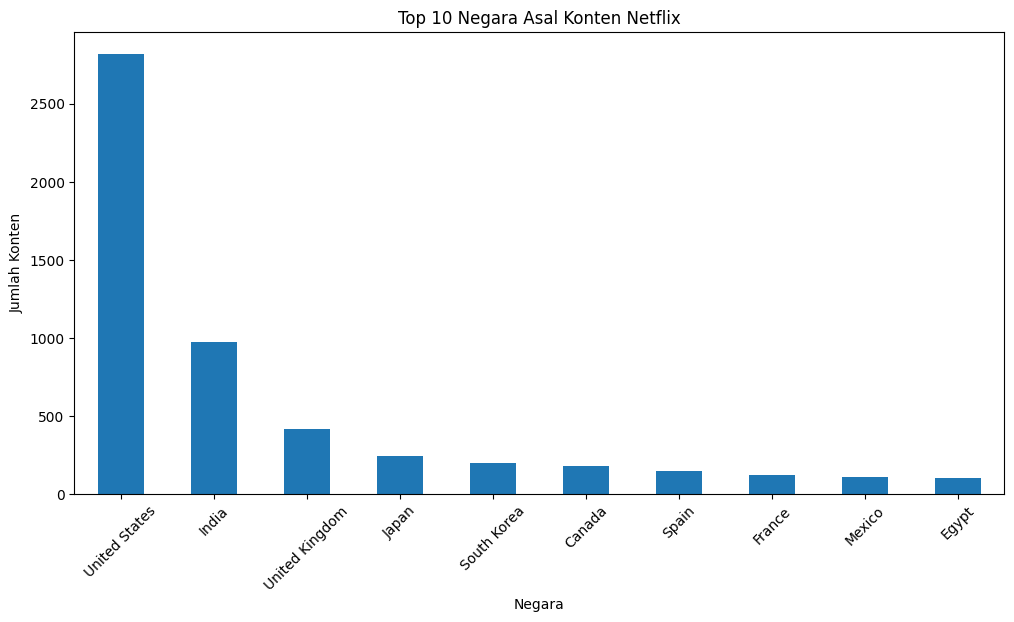

In [16]:
# Distribusi negara (country) 10 teratas
plt.figure(figsize=(12,6))
df['country'].value_counts().dropna().head(10).plot(kind='bar')
plt.title('Top 10 Negara Asal Konten Netflix')
plt.xlabel('Negara')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation=45)
plt.show()

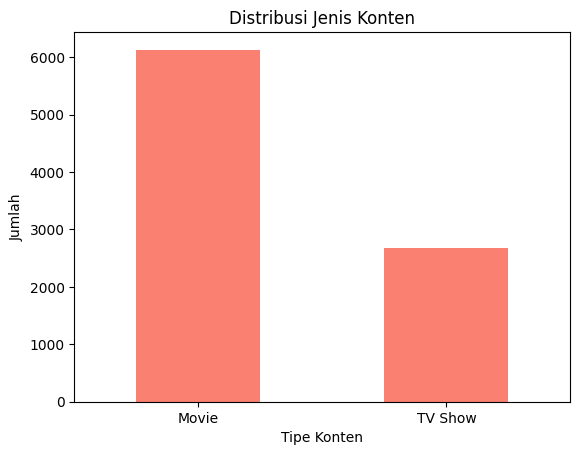

In [19]:
# Distribusi jenis konten (type) 10 teratas
df['type'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribusi Jenis Konten')
plt.xlabel('Tipe Konten')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

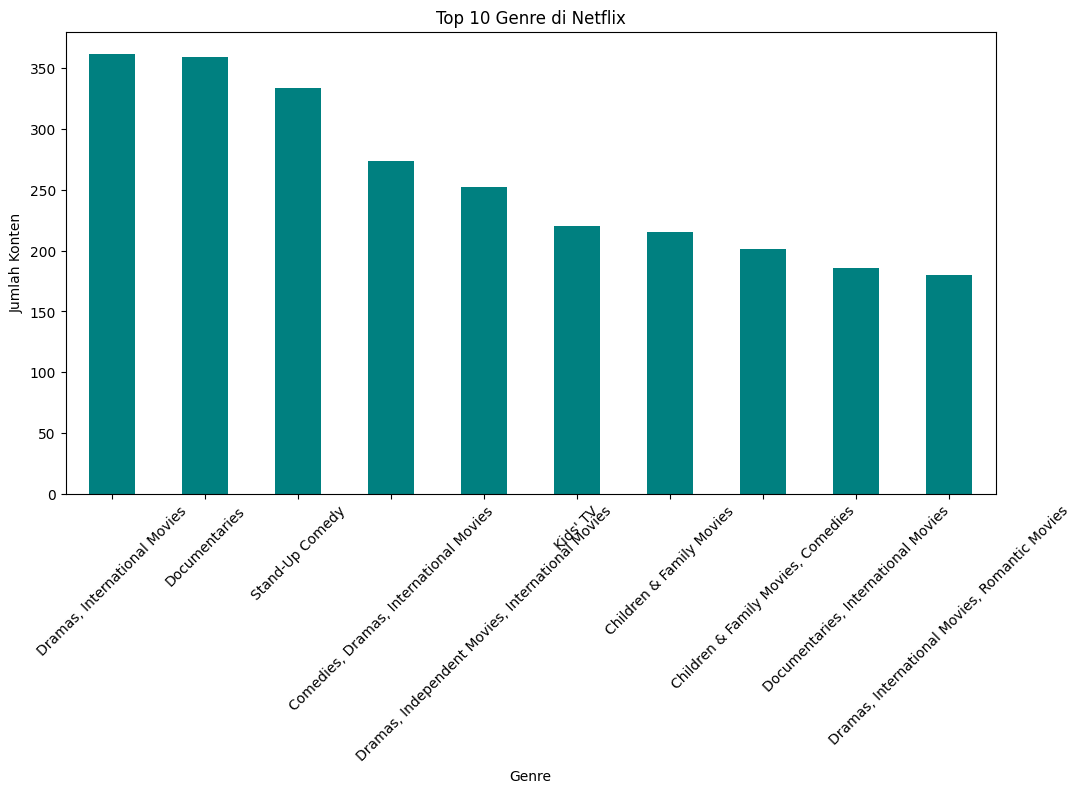

In [26]:
# Distribusi listed_in (genre) 10 teratas
plt.figure(figsize=(12,6))
df['listed_in'].value_counts().head(10).plot(kind='bar', color='teal')
plt.title('Top 10 Genre di Netflix')
plt.xlabel('Genre')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation=45)
plt.show()

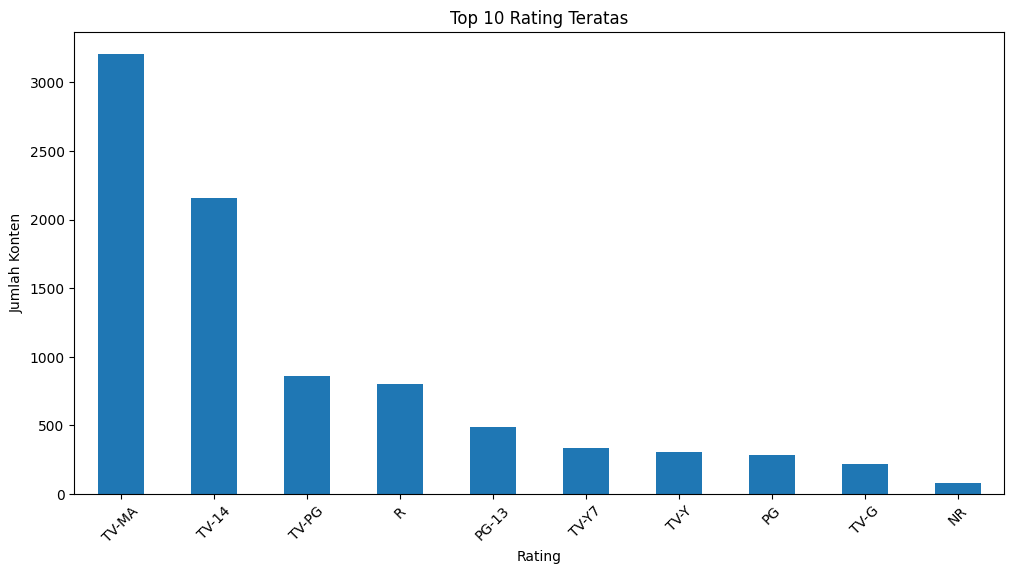

In [27]:
# Visualisasi distribusi 10 rating teratas
plt.figure(figsize=(12,6))
df['rating'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Rating Teratas')
plt.xlabel('Rating')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation=45)
plt.show()

Pada tahap Data Understanding ini, terdiri dari 8.807 baris dan 12 kolom yang berisi informasi terkait konten yang tersedia di platform Netflix. Informasi umum yang diperoleh dari df.info() menunjukkan bahwa sebagian besar kolom berisi data bertipe objek (string), sementara release_year bertipe numerik (integer). Beberapa kolom seperti director, cast, country, date_added, dan rating memiliki nilai yang hilang (missing values), sehingga perlu diperhatikan dalam analisis lebih lanjut. Statistik deskriptif (df.describe()) mengungkapkan data numerik release_year yang mencakup rentang tahun rilis konten dari masa lalu hingga yang terbaru. Kolom kategorikal memiliki variasi yang beragam, seperti banyaknya genre, jenis konten, dan negara asal produksi. Visualisasi distribusi menunjukkan bahwa mayoritas konten berasal dari negara-negara utama seperti United States, India, dan United Kingdom. Jenis konten yang paling banyak adalah Movies, diikuti oleh TV Shows. Genre yang paling populer mencakup kategori seperti Dramas, Comedies, dan Documentaries. Sedangkan untuk rating, sebagian besar konten memiliki rating yang umum seperti TV-MA, TV-14, dan TV-PG.

# **Data Preparation**

In [28]:
# Menghapus semua baris yang memiliki nilai NaN
df = df.dropna()

In [29]:
# Mengecek kembali missing value
df.isna().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,0
date_added,0
release_year,0
rating,0
duration,0


Setelah dilakukan penghapusan semua baris yang mengandung nilai kosong menggunakan df.dropna(), hasilnya menunjukkan bahwa seluruh nilai kosong telah dihilangkan, dan dataset kini hanya berisi baris dengan data lengkap.

# **TF-IDF Vectorizer**

TF-IDF Vectorizer diaplikasikan pada kolom genre (listed_in) untuk mengubah informasi kategori film menjadi bentuk numerik yang dapat diproses secara matematis. Dengan menghitung bobot kepentingan tiap kata dalam genre melalui TF-IDF, setiap film diwakili oleh sebuah vektor yang mencerminkan karakteristik genre uniknya. Vektor-vektor ini kemudian disusun dalam bentuk DataFrame dengan baris sebagai judul film dan kolom sebagai fitur genre, memudahkan perhitungan kesamaan antar film untuk keperluan rekomendasi berbasis konten.

In [30]:
data = df
data.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8754,s8755,Movie,Wolves,Bart Freundlich,"Michael Shannon, Carla Gugino, Taylor John Smi...",United States,"March 29, 2019",2016,R,109 min,"Dramas, Independent Movies, Sports Movies",A promising high school basketball player has ...
6154,s6155,Movie,An American Tail: The Treasures of Manhattan I...,Larry Latham,"Thomas Dekker, Dom DeLuise, Pat Musick, Nehemi...",United States,"April 1, 2018",2000,G,79 min,Children & Family Movies,When Fievel and friends go hunting for buried ...
551,s552,Movie,Haseen Dillruba,Vinil Mathew,"Taapsee Pannu, Vikrant Massey, Harshvardhan Ra...",India,"July 2, 2021",2021,TV-MA,136 min,"International Movies, Romantic Movies, Thrillers",Under investigation as a suspect in her husban...
5440,s5441,Movie,Shimmer Lake,Oren Uziel,"Benjamin Walker, Rainn Wilson, Rob Corddry, Ad...","Canada, United States","June 9, 2017",2017,TV-MA,87 min,"Dramas, Independent Movies, Thrillers","Unfolding in reverse time, this darkly comic c..."
6071,s6072,Movie,Aadu 2,Midhun Manuel Thomas,"Jayasurya, Vinayakan, Sunny Wayne, Vijay Babu,...",India,"May 15, 2018",2017,TV-MA,150 min,"Comedies, International Movies",When Shaji Pappan and his gang of goofy outlaw...


In [35]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data listed_in
tf.fit(data['listed_in'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'anime', 'british', 'children', 'classic',
       'comedies', 'comedy', 'crime', 'cult', 'documentaries',
       'docuseries', 'dramas', 'faith', 'family', 'fantasy', 'features',
       'fi', 'horror', 'independent', 'international', 'kids', 'korean',
       'language', 'lgbtq', 'movies', 'music', 'musicals', 'mysteries',
       'nature', 'reality', 'romantic', 'sci', 'science', 'series',
       'shows', 'spanish', 'spirituality', 'sports', 'stand', 'talk',
       'teen', 'thrillers', 'tv', 'up'], dtype=object)

In [36]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['listed_in'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(5332, 45)

In [37]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.62655199,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [41]:
# Membuat DataFrame TF-IDF dengan:
# - baris = judul film/serial (title)
# - kolom = genre/kategori (listed_in)

df_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data['title']
)

# Menampilkan sampel 22 kolom dan 22 baris secara acak
df_tfidf.sample(22, axis=1).sample(22, axis=1)

,adventure,crime,international,fantasy,romantic,independent,talk,anime,fi,spirituality,...,cult,thrillers,korean,classic,british,music,teen,lgbtq,comedies,mysteries
title,,,,,,,,,,,,,,,,,,,,,
Sankofa,0.0,0.0,0.376054,0.0,0.000000,0.630015,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
The Great British Baking Show,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.440233,0.000000,0.0,0.0,0.000000,0.0
The Starling,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.772283,0.0
Je Suis Karl,0.0,0.0,0.619492,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
Jeans,0.0,0.0,0.353917,0.0,0.634682,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.441448,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zinzana,0.0,0.0,0.408262,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.752119,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
Zodiac,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.799972,0.494378,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
Zombieland,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.487333,0.0


Matriks TF-IDF berisi 8807 judul film dan 45 genre unik, dimana setiap nilai mencerminkan seberapa kuat keterkaitan sebuah film dengan genre tertentu. Representasi ini memudahkan analisis kesamaan genre antar film untuk sistem rekomendasi berbasis konten.

# **Modeling**

## **Cosine Similarity**

Cosine similarity diterapkan untuk menilai sejauh mana dua film memiliki kemiripan genre, dengan memanfaatkan representasi vektor TF-IDF dan DataFrame sebagai alat visualisasi tingkat kemiripan tersebut.

In [42]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.24512115, ..., 0.16248587, 0.13658052,
        0.33912223],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24512115, 0.        , 1.        , ..., 0.37635857, 0.31635521,
        0.18609405],
       ...,
       [0.16248587, 0.        , 0.37635857, ..., 1.        , 0.27057992,
        0.061679  ],
       [0.13658052, 0.        , 0.31635521, ..., 0.27057992, 1.        ,
        0.05184543],
       [0.33912223, 0.        , 0.18609405, ..., 0.061679  , 0.05184543,
        1.        ]])

In [44]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada beberapa judul film secara acak
cosine_sim_df.sample(20, axis=1).sample(20, axis=0)

Shape: (5332, 5332)


title,Race 2,Zed Plus,Sleeping with Other People,5CM,Elles étaient en guerre (1914-1918),Lifechanger,Ana e Vitória,"Justice, My Foot!",You Carry Me,Us and Them,One Like It,Un plus une,Karthik Calling Karthik,Geez & Ann,Night Moves,"The Goods: Live Hard, Sell Hard",The Next Three Days,Dangal,Harry and Snowman,Reincarnated
title,,,,,,,,,,,,,,,,,,,,
A Remarkable Tale,0.217138,0.864305,0.489564,0.545633,0.369228,0.174942,0.569287,0.610305,0.545633,0.436696,0.449154,0.864305,0.359587,0.436696,0.112246,0.707432,0.000000,0.364033,0.093749,0.0
Mara,0.047066,0.093585,0.078146,0.118268,0.080032,0.861089,0.104665,0.066082,0.118268,0.139604,0.143586,0.093585,0.556328,0.139604,0.487717,0.000000,0.555678,0.116374,0.057070,0.0
Girlfriend's Day,0.061486,0.466248,0.907527,0.154504,0.104553,0.492217,0.329093,0.329228,0.154504,0.182376,0.663646,0.466248,0.101823,0.182376,0.542366,0.562593,0.000000,0.152030,0.074555,0.0
Unfriended,0.047066,0.093585,0.078146,0.118268,0.080032,0.861089,0.104665,0.066082,0.118268,0.139604,0.143586,0.093585,0.556328,0.139604,0.487717,0.000000,0.555678,0.116374,0.057070,0.0
End of Watch,0.564202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.792166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Everyday I Love You,0.189821,0.566125,0.323070,0.715442,0.322777,0.225555,0.321903,0.266518,0.715442,1.000000,0.586354,0.566125,0.471496,1.000000,0.282486,0.000000,0.182537,0.475231,0.120871,0.0
Pahuyut Fighting Beat,0.642425,0.292134,0.086859,0.369185,0.249826,0.118369,0.221529,0.901994,0.369185,0.295476,0.303906,0.292134,0.243303,0.295476,0.075948,0.000000,0.000000,0.246311,0.063432,0.0
Ip Man 3,0.597757,0.456093,0.234692,0.576390,0.232456,0.110139,0.206126,0.839278,0.576390,0.412373,0.424138,0.456093,0.379856,0.412373,0.205210,0.000000,0.178266,0.343757,0.059022,0.0
The Hurricane Heist,0.564202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.792166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Hasil cosine similarity ini menunjukkan tingkat kemiripan antar judul film berdasarkan kategori atau genre yang mereka miliki. Nilai 1.0 pada diagonal menunjukkan bahwa setiap film tentu saja identik dengan dirinya sendiri. Nilai di luar diagonal menunjukkan seberapa mirip satu film dengan film lainnya — semakin mendekati 1, semakin tinggi kesamaan genre atau kategori di antara kedua film tersebut. Nilai yang mendekati 0 berarti film tersebut memiliki sedikit atau tidak ada kesamaan kategori. Matriks ini dapat digunakan untuk merekomendasikan film yang serupa berdasarkan konten genre.

## **Mendapatkan Rekomendasi**

Fungsi ```product_recommendations``` menghasilkan daftar produk yang paling mirip dengan produk yang dipilih, menggunakan nilai ```cosine similarity``` untuk mengurutkan rekomendasi berdasarkan tingkat kesamaan kategori. Fungsi ini juga menyajikan detail kategori agar pengguna dapat memahami alasan kemiripan tersebut.

In [46]:
print(data.columns)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [47]:
items = data[['title', 'listed_in']]

In [49]:
def product_recommendations(nama_show, similarity_data=cosine_sim_df, items=data[['title', 'listed_in']], k=10):
    # Cek apakah nama show ada di kolom similarity
    if nama_show not in similarity_data.columns:
        raise ValueError(f"Show '{nama_show}' tidak ditemukan di data similarity.")

    # Mengambil indeks top-k similarity tertinggi
    index = similarity_data.loc[:, nama_show].to_numpy().argpartition(-k-1)[-k-1:]

    # Urutkan berdasarkan similarity tertinggi
    sorted_index = index[similarity_data.loc[:, nama_show].to_numpy()[index].argsort()[::-1]]

    # Ambil nama-nama show terdekat
    closest = similarity_data.columns[sorted_index]

    # Hapus show yang sama dari hasil rekomendasi
    closest = closest.drop(nama_show, errors='ignore')

    # Gabungkan dengan genre
    return pd.DataFrame(closest, columns=['title']).merge(items, on='title').head(k)

In [57]:
# Menampilkan informasi title dengan nama 'Holiday Rush'
data[data.title.eq('Holiday Rush')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3218,s3219,Movie,Holiday Rush,Leslie Small,"Romany Malco, Sonequa Martin-Green, Darlene Lo...",United States,"November 28, 2019",2019,TV-PG,94 min,"Children & Family Movies, Dramas",A widowed radio DJ and his four spoiled kids n...


In [58]:
# Mendapatkan rekomendasi title yang mirip dengan Holiday Rush
product_recommendations('Holiday Rush')

,title,listed_in
0,Wish Man,"Children & Family Movies, Dramas"
1,Big Miracle,"Children & Family Movies, Dramas"
2,A Champion Heart,"Children & Family Movies, Dramas"
3,White Fang,"Children & Family Movies, Dramas"
4,You Are My Home,"Children & Family Movies, Dramas"
5,Hachi: A Dog's Tale,"Children & Family Movies, Dramas"
6,Balto,"Children & Family Movies, Dramas"
7,The Karate Kid Part III,"Children & Family Movies, Dramas"
8,The Indian in the Cupboard,"Children & Family Movies, Dramas"
9,Hugo,"Children & Family Movies, Dramas"


 Telah berhasil membangun sistem rekomendasi film dan acara TV Netflix menggunakan TF-IDF untuk memproses genre, dan Cosine Similarity untuk mengukur kemiripan antar judul. Fungsi ```product_recommendations``` digunakan untuk merekomendasikan judul-judul serupa berdasarkan genre, seperti pada contoh "Holiday Rush".